In [1]:
from scipy.stats import uniform
from numpy import array
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib as mp
import time
import seaborn as sb
import matplotlib as mpl 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.externals import joblib
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import random
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, precision_recall_curve


/cs/home/ybk1/Documents/Modules/CS5014/Classification/env/lib64/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Sections of the report 

-	Introduction
-	Methods
    -	Cleaning the data and creating new input features
    - Analysing and visualising the data
    - Preparing the inputs and choosing suitable features
    - Selecting and training a model
-	Evaluation

-	Conclusion


## 1. Introduction

This study will be taking a data driven approach towards classifying images of seals. The dataset used 

## 2. Method

### 2.1 Loading and cleaning the data set


In [2]:
# Load the datasets

#binary datasets
X_train_binary = pd.read_csv('/data/CS5014-P2/binary/X_train.csv', header=None)
Y_train_binary = pd.read_csv('/data/CS5014-P2/binary/Y_train.csv', header=None)
X_test_binary = pd.read_csv('/data/CS5014-P2/binary/X_test.csv', header=None)

#multi datasets
X_train_multi = pd.read_csv('/data/CS5014-P2/multi/X_train.csv', header=None)
Y_train_multi = pd.read_csv('/data/CS5014-P2/multi/Y_train.csv', header=None)
X_test_multi = pd.read_csv('/data/CS5014-P2/multi/X_test.csv', header=None)

###  Cleaning the dataset

a) **Check for Null-values and inconsistent data types:** Upon looking at that dataset, we can see that each column has an equal amount of non-null values, indicating that there are **no instances** of missing data. Moreover, all the data types are float64, indicating a consistency in data format

In [3]:
# Check for Null-values
print(X_train_multi.info(null_counts=True))
print(X_train_binary.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Columns: 964 entries, 0 to 963
dtypes: float64(964)
memory usage: 457.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Columns: 964 entries, 0 to 963
dtypes: float64(964)
memory usage: 457.5 MB
None


b) **Check for duplicate values**: No duplicate values were found

In [4]:
# remove duplicate rows
datasets = [X_train_binary,Y_train_binary, X_test_binary, X_train_multi, X_train_multi, X_test_multi]

for data in datasets:
    duplicate_rows = data[data.duplicated()]
    print(len(duplicate_rows))

0
62208
0
0
0
0


No null values, no duplicate and all the data types were for the dtype float64. Nothing needed to change so will proceed to visualising the dataset


### 2.1.2 Create a validation set

Despite there being a already a test set in place, a preliminary test set was created, to evaluate the performance of the model and to see how well the model could
generalise on unseen data. The training data was split with an 80/20 split in stratified fashion, in order to keep the proportion of the classes as the dataset
was already heavily imbalanced.

In [5]:
# Splits the training set
X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(X_train_binary, Y_train_binary, test_size=0.20, stratify=Y_train_binary, random_state=27)
X_train_M, X_val_M, y_train_M, y_val_M = train_test_split(X_train_multi, Y_train_multi, test_size=0.20, stratify=Y_train_multi, random_state=27)

# Resets the indexes
X_train_B = X_train_B.reset_index(drop=True)
X_val_B = X_val_B.reset_index(drop=True)
y_train_B = y_train_B.reset_index(drop=True)
y_val_B = y_val_B.reset_index(drop=True)

X_train_M = X_train_M.reset_index(drop=True)
X_val_M = X_val_M.reset_index(drop=True)
y_train_M = y_train_M.reset_index(drop=True)
y_val_M = y_val_M.reset_index(drop=True)

### 2.2 Analysing and Visualising the dataset

#### 2.2.1 Visualising the images


The dataset has 62210 images, with around 964 features. To visualise the images, I sliced the first
900 columns to get the Histogram of Orientated Gradient (HOG) features and picked an image from each class found in the Y_train datasets

Figure 1 below, showes the images taken from the binary dataset, where classes are either background and seal. 
Figure 2, shows images from the multi dataset, where images are background, dead pup, whitecoat, moulted pup, juvenile

In [6]:
bin_classes = ['background','seal']
mult_classes = ['background','dead pup', 'whitecoat', 'moulted pup', 'juvenile']

def get_rows_and_titles(classes, dataset, num):
    """
    Method for getting the row numbers and titles for each class
    """
    rows = np.array([])
    titles = np.array([])
    for i in classes:
        filt = dataset.iloc[:,0] == i
        filtered_data = dataset[filt].head(num)
        rows = np.concatenate([rows, filtered_data.index.values])
        titles = np.concatenate([titles, array(filtered_data.iloc[:,0])])
    
    return rows.astype(int), titles  
      
        
bin_rows, bin_titles = get_rows_and_titles(bin_classes, y_train_B,1)
mult_rows, mult_titles = get_rows_and_titles(mult_classes, y_train_M,1)

bin_titles

array(['background', 'seal'], dtype=object)

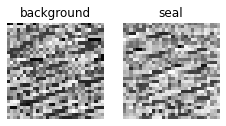

In [7]:
# classes in the  binary dataset
no_rows_bin  = 2
no_rows_mult = 2
def print_images(no_rows,row_numbers, titles, dataset, width, height):
    """
    Converts the HoG features provided into a 30 x 30 image. 
    Plots the images seen in Figure 1 of the report. 
    """
    fig = plt.figure(figsize=(width, height))
    for i in range(1, len(row_numbers) +1): 
        output = array(dataset.iloc[row_numbers[i-1], :900])
        output_image = output.reshape(30, 30)
        fig.add_subplot(no_rows, 5, i)
        plt.imshow(output_image, cmap = mpl.cm.binary, interpolation="nearest")
        plt.title(titles[i-1])
        plt.axis("off")
        
    plt.show()

print_images(no_rows_bin, bin_rows, bin_titles, X_train_B,10,5)

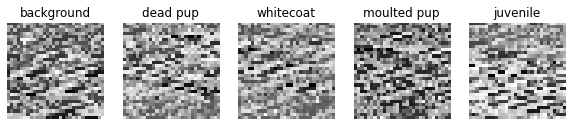

In [8]:
print_images(no_rows_mult, mult_rows, mult_titles, X_train_M,10,5)

In both datasets, we can see that the "backgound" classes appears to have the least amount of dark pixelation compared to the others. 
In the mult-classification dataset, the whitecoat image appears to be the most distinct

#### 2.2.2 Visualising the class distribution in the data

To understand the distribution of the classes in both the binary and multi datasets, I visualised the frequency distribution of the classes


In [9]:
# prepare data for visualisation
bin_freq= y_train_B.iloc[:,0].value_counts()
mult_freq= y_train_M.iloc[:,0].value_counts()

mult_classes = array(mult_freq.keys())
mult_data = mult_freq.values
bin_classes = array(bin_freq.keys())
bin_data = bin_freq.values

classes = [mult_classes, bin_classes]
mult_and_bin_freq = [mult_data, bin_data]
titles = ["Multi","Binary"]


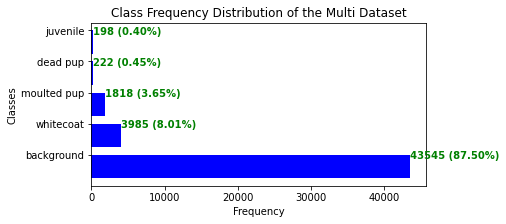

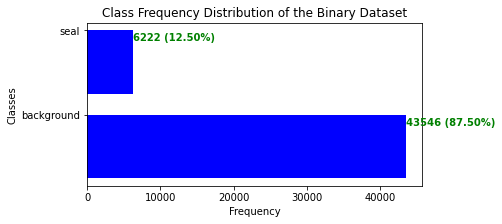

In [10]:
# X_train_multi.iloc[:,0].value_counts().plot(kind='barh') #horizontal bar plot

def get_pct(array, value):
    """
    Gets the percentage of a value in proportion to the sum of an array
    return: pct_string
    """
    pct = value/array.sum()
    pct_string =  " ({:.2%})".format(pct)
    return pct_string
#
def plot_class_dist(data,classes, title):
    """
    Plots a 2-D plot, showing the relationship between classes and frequency
    Plots the images seen in Figure 2 of the report. 
    """
    fig, ax = plt.subplots(figsize=(6, 3))    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(data))  # the x locations for the groups
    ax.barh(ind, data, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(classes, minor=False)
    plt.title("Class Frequency Distribution of the " + title +  " Dataset")
    plt.xlabel('Frequency')
    plt.ylabel('Classes')
    for i, v in enumerate(data):
        ax.text(v + 3, i + .25, str(v) + get_pct(data,v), color='green', fontweight='bold')
    plt.show()
    
for i in range(2):
    plot_class_dist(mult_and_bin_freq[i],classes[i],titles[i])

It is evident that both datasets are heavily skewed towards the background class, accounting for 87.5% of the dataset. Given this large proportion of the background class in the dataset,
it may be no suprise that the classification algorithm is able to classify the background class very well. On the other hand, the juvenile and moulted pup classes
account for 0.40% and 0.45% respectively. Given the skewed data set it will make sense to stratify the training sets to keep a consistent distribution. 

#### 2.2.3 Visualising Variance Using PCA and t-SNE

**PCA**

PCA is a popular technique for reducing the number of dimensions in a dataset whilst retaining most information. PCA preserves variances by identifying the axis that accounts for the largest amount of variance in the training set (hands on). It then finds a 2nd axis which is orthogonal to the first one, that accounts for the largest amount of remaining variance. In higher dimensions, PCA would find a 3rd axis and then an ith axis, based on the number of dimensions in the dataset. The vector that defines each axis is called the the Priniciapal component. For visualising purposes, I reduced the dimensions down to 3 dimensions and plotted the 1st and 2nd Principal componetns against each other. (See figure 5). Using the explained 
variance ratio, I found that 35.6% of the dataset's variance lied in the first axis, 20.1% in the 2nd axis and 14% in the 3rd axis. Thus the first three components accounted for 69.7% of the entire dataset. 

https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


We can see from Figure 3, that the data relating to the seal has the highest variance as it dominates the X axis of PCA 1. The data relating to background, appears to have a lower variance as it appears for the highest PCA values for PCA 2


**t-SNE**

original paper = http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
t-Distributed Stochastic Neighbor Embedding (t-SNE) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA it is not a mathematical technique but a probablistic one.


In [11]:
# scale binary dataset
std_B = StandardScaler().fit(X_train_B)
X_train_B_std = std_B.transform(X_train_B)
X_val_B_std = pd.DataFrame(std_B.transform(X_val_B))
X_test_binary_std = pd.DataFrame(std_B.transform(X_test_binary))

# scale multi dataset
std_M = StandardScaler().fit(X_train_M) # fit the training set
X_train_M_std = std_M.transform(X_train_M)
X_val_M_std = pd.DataFrame(std_M.transform(X_val_M))
X_test_multi_std = pd.DataFrame(std_M.transform(X_test_multi))

# data lists
X_train_std_list = [X_train_M_std, X_train_B_std]
Y_train_list = [y_train_M,y_train_B]
no_colors = [5,2]
   
def plot_pca(X_train_list,y_train_list, no_colors, titles):
    """
    Plots a 2-Dimensional plot of the PCA components.
    Plots the images seen Figure 3 of the report. 
    """
    plt.figure(figsize=(16,7))
    for j in range(2):
        
        # prepare data for visualisation
        y = array(y_train_list[j].iloc[:,0])
        feat_cols = ['pixel'+str(i) for i in range(X_train_B.shape[1])]
        df = pd.DataFrame(array(X_train_list[j]), columns=feat_cols)
        df['y'] = y
        df['label'] = df['y'].apply(lambda i: str(i))

        X, y = None, None

        # add random permuation for reproducability of the results
        np.random.seed(42)
        rndperm = np.random.permutation(X_train_list[j].shape[0])

        # Set PCA components
        N = 60000
        df_subset = df.loc[rndperm[:N],:].copy()
        data_subset = df_subset[feat_cols].values
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(data_subset)
        df_subset['pca-one'] = pca_result[:,0]
        df_subset['pca-two'] = pca_result[:,1] 
        df_subset['pca-three'] = pca_result[:,2]
        print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
        
        # plot PCA components 
        
        ax1 = plt.subplot(1, 2, j+1)
        sb.scatterplot(
            x="pca-one", y="pca-two",
            hue="y",
            palette=sb.color_palette("hls", no_colors[j]),
            data=df_subset,
            legend="full",
            alpha=0.3,
            ax=ax1
        )
        ax1.set_title(titles[j] + " dataset")

def plot_tsne(X_train_list,y_train_list, no_colors, titles):
    """
    Plots a 2-Dimensional plot of the t-SNE components
    Corresponds to Figure 4 of report. Make N=40000 if you would like to generate the image seen in the report, 
    however this takes a while to run. 
    """
    plt.figure(figsize=(16,7))
    for j in range(2):
        
        # prepare data for visualisation
        y = array(y_train_list[j].iloc[:,0])
        feat_cols = ['pixel'+str(i) for i in range(X_train_B.shape[1])]
        df = pd.DataFrame(array(X_train_list[j]), columns=feat_cols)
        df['y'] = y
        df['label'] = df['y'].apply(lambda i: str(i))

        X, y = None, None

        # add randome permuation for reproducability of the results
        np.random.seed(42)
        rndperm = np.random.permutation(X_train_list[j].shape[0])

        # Set PCA components
        N = 1000
        df_subset = df.loc[rndperm[:N],:].copy()
        data_subset = df_subset[feat_cols].values
        pca = PCA(n_components=100)
        pca_result = pca.fit_transform(data_subset)
        print('Cumulative variance explained by 100 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))
        
        #Set TSNE components
        time_start = time.time()
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(pca_result)
        print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
        df_subset['tsne-2d-one'] = tsne_results[:,0]
        df_subset['tsne-2d-two'] = tsne_results[:,1]

        # plot PCA components 
        
        ax1 = plt.subplot(1, 2, j+1)
        sb.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="y",
            palette=sb.color_palette("hls", no_colors[j]),
            data=df_subset,
            legend="full",
            alpha=0.3,
            ax=ax1
        )
        ax1.set_title(titles[j] + " dataset")
    
    
    
# for i in range (2):
# plot_tsne(X_train_std_list, Y_train_list, no_colors, titles)

### 2.3 Preparing the inputs and choosing suitable features (TODO)


The dataset is imbalanced - https://www.aaai.org/Papers/Workshops/2000/WS-00-05/WS00-05-001.pdf

#### 2.3.1 Choosing Suitable features 

Since the data is split up into three different groups, I decided to test different feature subsets using a baseline logistic regression, in order to choose a 
specific subset for further training and optimising. 

In [12]:
# Here i take the scaled training sets and then create dictionaries that store 4 feature subsets
"""
HoG Features
HoG Features + Normal distribution
HoG Features + Colour
All features
"""

def select_HoG_and_colour(X):
    """
    Selects the HoG and the three Colour histogram features
    """
    X = pd.DataFrame(X)
    X_HoG = X.iloc[:, :900]
    X_colour = X.iloc[:, 916:964]
    X = pd.concat([X_HoG, X_colour], axis=1)
    return X

# Binary dataset feature subsets
X_train_B_std = pd.DataFrame(X_train_B_std)
X_train_B_HoG = X_train_B_std.iloc[:, :900]
X_train_B_normal = X_train_B_std.iloc[:, :916]
X_train_B_colour = select_HoG_and_colour(X_train_B_std)
X_train_B_list = {'X_train_B': X_train_B, 'X_train_B_HoG': X_train_B_HoG,
                 'X_train_B_normal': X_train_B_normal, 'X_train_B_colour': X_train_B_colour}

# Binary dataset feature subsets
X_train_M_std = pd.DataFrame(X_train_M_std)
X_train_M_HoG = X_train_M_std.iloc[:, :900]
X_train_M_normal = X_train_M_std.iloc[:,:916]
X_train_M_colour = select_HoG_and_colour(X_train_M_std)
X_train_M_list = {'X_train_M': X_train_M, 'X_train_M_HoG': X_train_B_HoG,
                 'X_train_M_normal': X_train_M_normal, 'X_train_M_colour': X_train_M_colour}


In [13]:
# select Hog features + colour for the validation and test set

# Binary dataset
X_val_B_colour = select_HoG_and_colour(X_val_B_std)
X_test_binary_colour = select_HoG_and_colour(X_test_binary_std)

# multi
X_val_M_colour = select_HoG_and_colour(X_val_M_std)
X_test_multi_colour = select_HoG_and_colour(X_test_multi_std)



In [14]:
# def get_corr(X_train,y_train):
#     """
#     Gets the correlation of the features between the 
#     """
#     # concatenate our training data back together
#     X_train = pd.DataFrame(X_train)
#     y_train = y_train.rename(columns={0: "classes"})
#     X = pd.concat([X_train, y_train], axis=1)
#     convert_classes = {"classes":     {"background": 0, "seal": 1}}
#     X.replace(convert_classes, inplace=True)
#     corr = X.corr()
#     top_feat = corr['classes'].sort_values(ascending = False).head(10)
#     bot_feat = corr['classes'].sort_values(ascending = True).head(10)
#     return top_feat,bot_feat


#### 2.3.2 Scaling

The paper mentioned that scaling was important for getting good results as normalisation helps to remove the effect of local lights differences. 

http://www.geocities.ws/talh_davidc/#cst_extract

#### 2.3.3 Dimensionality reduction with PCA

Earlier dimensionality reduction was used for visualisation, now it will be used for training and evaluation purposes. As opposed to only used 2 principal components
, the aim would be to find the optimal amount of principal components so as to reduce the dimensions while having a high amount of variance in the data > 95%


In [15]:
pca = PCA()
pca.fit(X_train_M_colour)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1
d

474

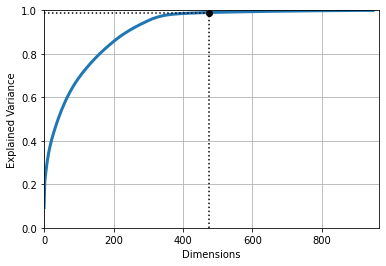

In [16]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 964, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.99], "k:")
plt.plot([0, d], [0.99, 0.99], "k:")
plt.plot(d, 0.99, "ko")
plt.grid(True)
plt.show()

In [17]:
# use minimum number of dimensions required to preserve 99% of the variance
# binary dataset
pca_B = PCA(n_components=474)
X_train_B_PCA = pca_B.fit_transform(X_train_B_colour)
X_val_B_PCA = pca_B.transform(X_val_B_colour)
X_test_binary_PCA = pca_B.transform(X_test_binary_colour)

# multi dataset
pca_M = PCA(n_components=474)
X_train_M_PCA = pca_M.fit_transform(X_train_M_colour)
X_val_M_PCA = pca_M.transform(X_val_M_colour)
X_test_multi_PCA = pca_M.transform(X_test_multi_colour)


In [18]:
# This was used to compare the performance of PCA against not using it

# time_start = time.time()
# run_clf(X_train_M_PCA, y_train_M,"X_train_M","multi",True,'LogReg')
# print('Prediction done! Time elapsed: {} seconds'.format(time.time()-time_start))

# time_start2 = time.time()
# run_clf(X_train_M_colour, y_train_M,"X_train_M","multi",True,'LogReg')
# print('Prediction done! Time elapsed: {} seconds'.format(time.time()-time_start))

#### 2.3.4 Resampling

Study on why PCA should be done before - https://arxiv.org/ftp/arxiv/papers/1403/1403.1949.pdf

To address the issue of having an unbalanced dataset, this study investigated resampling techniques such as oversampling and undersampling

- Oversampling: Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.
- Undersampling: is a method of reducing copies of a majority class

In [19]:

def oversample(X_train, y_train):
    """
    Oversamples the minority class of a binary dataset and
    return: X_train_ov, y_train_ov
    """
    # concatenate our training data back together
    X_train = pd.DataFrame(X_train)
    y_train = y_train.rename(columns={0: "classes"})
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X_train, y_train)
    print(y_res.iloc[:,0].value_counts())
    oversampled_data = [X_res, y_res]
    return oversampled_data
   
def undersample_bin(X_train, y_train):
    """
    Undersamples the minority class of a binary dataset and
    return: X_train_ov, y_train_ov
    """
    # concatenate our training data back together
    X_train = pd.DataFrame(X_train)
    y_train = y_train.rename(columns={0: "classes"})
    X = pd.concat([X_train, y_train], axis=1)

    # separate minority and majority classes
    not_seal_bool = X['classes']=='background'
    not_seal = X[not_seal_bool]
    seal_bool = X['classes']=='seal'
    seal = X[seal_bool]

    # downsample majority
    not_seal_downsampled = resample(not_seal,
                                    replace = False, # sample without replacement
                                    n_samples = len(seal), # match minority n
                                    random_state = 27) # reproducible results

    # combine minority and downsampled majority
    downsampled = pd.concat([not_seal_downsampled, seal])
    y_train_down = downsampled['classes']
    print(y_train_down.value_counts())
    X_train_down = downsampled.drop(columns='classes', axis=1)
    undersampled_data = [X_train_down, y_train_down]
    return undersampled_data

def undersample_multi(X_train, y_train):
    """
    Oversamples the minority class of a binary dataset and
    return: X_train_ov, y_train_ov
    """
    # concatenate our training data back together
    X_train = pd.DataFrame(X_train)
    y_train = y_train.rename(columns={0: "classes"})
    undersample_background = {'background': 3985}
    rus = RandomUnderSampler(undersample_background , random_state=42, )
    X_res, y_res = rus.fit_resample(X_train, y_train)
    print(y_res.iloc[:,0].value_counts())
    undersampled_data = [X_res, y_res]
    return undersampled_data


### Generating synthetic data

Paper on the combination of PCA and SMOTE: https://arxiv.org/ftp/arxiv/papers/1403/1403.1949.pdf

A technique similar to upsampling is to create synthetic samples. Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. 
SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.



In [20]:
# SMOTE

def smote(X_train, y_train):
    sm = SMOTE(random_state=27)
    X_train, y_train = sm.fit_sample(X_train, y_train)
    print(y_train.iloc[:,0].value_counts())
    smote_data = [X_train, y_train]
    return smote_data


### Under- and Oversampling 

After finding out that smote 

In [21]:
# undersample by coping and then oversampling

# undesample background
X_train_undersampled_multi = undersample_multi(X_train_M_PCA, y_train_M)[0]
y_train_undersampled_multi = undersample_multi(X_train_M_PCA, y_train_M)[1]

under_and_over_M = smote(X_train_undersampled_multi, y_train_undersampled_multi)

background     3985
whitecoat      3985
moulted pup    1818
dead pup        222
juvenile        198
Name: classes, dtype: int64
background     3985
whitecoat      3985
moulted pup    1818
dead pup        222
juvenile        198
Name: classes, dtype: int64
dead pup       3985
background     3985
whitecoat      3985
moulted pup    3985
juvenile       3985
Name: classes, dtype: int64


### Resampled Datasets

Below is a dictionary of all the resampled datasets. It is commented out by default as the top performing datasets were found. 
Remove comment if you would like to check it again. 

In [22]:
# only uncomment if you want to run graph that compares all the resampled datasets as this takes a while to run
resampled_binary_data = {'PCA + SMOTE':smote(X_train_B_PCA,y_train_B), 
                  'PCA + Oversampled': oversample(X_train_B_PCA, y_train_B),
                  'PCA + Undersampled': undersample_bin(X_train_B_PCA,y_train_B),
                    'PCA': [X_train_B_PCA,y_train_B]}

resampled_multi_data =  {'PCA + Under- and Oversampling': under_and_over_M,
                    'PCA': [X_train_M_PCA,y_train_M]}

background    43546
seal          43546
Name: 0, dtype: int64
background    43546
seal          43546
Name: classes, dtype: int64
background    6222
seal          6222
Name: classes, dtype: int64


In [23]:
# Chosen datasets after running logistic regression
smote_PCA_binary = smote(X_train_B_PCA,y_train_B)


background    43546
seal          43546
Name: 0, dtype: int64


In [24]:
X_train_B_smote_PCA = smote_PCA_binary[0]
Y_train_B_smote_PCA = smote_PCA_binary[1]
X_train_M_PCA



array([[ -3.99147577,   0.79070784,   8.74260453, ...,   0.27320287,
         -0.14820777,   0.05070578],
       [  9.4536847 ,  -1.34029447,  -2.58709995, ...,  -0.04005475,
          0.158221  ,   0.1787577 ],
       [ -4.18172596,  -0.56258941, -10.10152219, ...,   0.03766718,
         -0.10617006,   0.15373491],
       ...,
       [  1.12905071,  -3.54805763,   1.2824803 , ...,  -0.04113672,
         -0.3351477 ,  -0.45417891],
       [  1.12657684,  -4.61707487,   1.38169317, ...,   0.12797731,
          0.09409858,   0.18354182],
       [ -2.92723975,   2.57859532,  -4.65801747, ...,   0.8961402 ,
         -0.17699327,  -0.15719825]])

## 2.4 Training The Model 

### 2.4.1 Models used 

- Logistic regression
- MLP
- Random Forrest - imbalanced dataset with RF https://ieeexplore.ieee.org/abstract/document/4410397



The first models that I will use are logistic regression and SVM

In [25]:
#fit the logistic regression

# def choose_predict(classifier, X,Y,is_cross_val):
#     if is_cross_val == True:
#         return cross_val_predict(classifier, X, Y, cv=3)
#     else:
#         return classifier.predict(X)

bin_classes = 'background','seal'
mult_classes = 'background','dead pup', 'whitecoat', 'moulted pup', 'juvenile'

def choose_clf(clf, dataset_type):
    if dataset_type == 'binary':
        clf_dict= {
            'LogReg':LogisticRegression(random_state=0, max_iter=500, solver ='sag',  tol=0.001,),
            'RF': RandomForestClassifier(max_depth=120, n_estimators=91, random_state=0, max_features = 72, 
                                   n_jobs=-1),
            'MLP': MLPClassifier(solver='adam', tol=0.0001, learning_rate_init =0.001, momentum =0.2, alpha =0.8,
                    n_iter_no_change=10, hidden_layer_sizes =(100,100), max_iter=10000, random_state=27),
            'LogReg_RS':LogisticRegression(random_state=0, C=0.03, max_iter=500, solver ='sag',  tol=0.001),
        }
        return clf_dict[clf]
    else:
        clf_dict= {
            'LogReg':LogisticRegression(random_state=0, max_iter=500, solver ='sag',  tol=0.001,),
            'RF': RandomForestClassifier(max_depth=30, n_estimators=99, random_state=0, max_features = 51, 
                                   n_jobs=-1),
            'MLP': MLPClassifier(solver='adam', tol=0.0001, learning_rate_init =0.001, momentum =0.4, alpha =0.6,
                    n_iter_no_change=10, hidden_layer_sizes =(100,100), max_iter=10000, random_state=27),
            'LogReg_RS':LogisticRegression(random_state=0, C=2.5, max_iter=500, solver ='sag',  tol=0.001),
        }
        return clf_dict[clf]
        
        
def get_results(y_test, y_pred, dataset_type):
    results = {}
    if dataset_type == 'binary':
        results["Accuracy"] = accuracy_score(y_test, y_pred)
        results["Precision"] = precision_score(y_test, y_pred, pos_label='seal')
        results["Recall"] = recall_score(y_test, y_pred, pos_label='seal')
        results["F1 Score"] = f1_score(y_test, y_pred, pos_label='seal')
        results["Balanced Accuracy"] = balanced_accuracy_score(y_test, y_pred)
        return results
    else:
        results["Accuracy"] = accuracy_score(y_test, y_pred)
        results["Precision"] = precision_score(y_test, y_pred, average='macro')
        results["Recall"] = recall_score(y_test, y_pred, average='macro')
        results["F1 Score"] = f1_score(y_test, y_pred, average='macro')
        results["Balanced Accuracy"] = balanced_accuracy_score(y_test, y_pred)
        return results
    
def show_confusion_matrix(clf, X_test, y_test, class_names, title):
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, normalize='true', xticks_rotation = 'vertical')
    disp.ax_.set_title(title)
    plt.figure(figsize=(20,20))
    plt.show()
    

def run_clf(X_train, y_train, X_test, y_test, dataset_name, dataset_type,clf,class_names):
    """
    Trains the model a chosen classifier and scores it on the given dataset, providing results
    for accuracy, precision, recall, f1 score and a confusion matrix
    :return: model, results
    """""
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    results = {}
    model = choose_clf(clf,dataset_type).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    results = get_results(y_test, y_pred, dataset_type)
    cm_title = "{1} Confusion Matrix on the {0} dataset: \n".format(dataset_name,clf)
    print("{1} Performance Results on the {0} dataset: \n".format(dataset_name,clf) + str(results))
    print(cm)
    show_confusion_matrix(model, X_test, y_test, class_names, cm_title)
    return model, results


In [26]:
def run_log_on_all_subsets():
    """
    Runs logistic regresssion on all the resampled binary datasets.
    Outputs the data seen in Table 1 of the report
    """
    for key in X_train_B_list:
        time_start = time.time()
        model, results = run_clf(X_train_B_list[key], y_train_B,
                                 X_val_B, y_val_B, key,"binary",'LogReg', None)
        print('Prediction done! Time elapsed: {} seconds'.format(time.time()-time_start))
        
    for key in X_train_M_list:
        time_start = time.time()
        model, results = run_clf(X_train_M_list[key], y_train_M,
                                 X_val_M, y_val_M, key,"binary",'LogReg', None)
        print('Prediction done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    

### 2.4.2 Finding the best resampled dataset

To find the top performing resampled dataset after PCA, I ran logistic regression on each resampled dataset from both 
the multi and binary datasets and then computed the results. 



In [27]:
# Store the performnance results of the resampled datasets for plotting



def run_log_on_resampled_bin_data():
    """
    Runs logistic regresssion on all the resampled binary datasets.
    Outputs the data seen in Table 3 of the report. 
    """
    for key in resampled_binary_data:
        time_start = time.time()
        model, results = run_clf(resampled_binary_data[key][0], resampled_binary_data[key][1],
                                 X_val_B_PCA, y_val_B, key,"binary",'LogReg', bin_classes)
        print('Prediction done! Time elapsed: {} seconds'.format(time.time()-time_start))

# run_log_on_resampled_bin_data()

In [28]:
resampled_mult_accuracies = []
resampled_mult_f1_score = []
resampled_mult_datasets = []

def run_log_on_resampled_mult_data():
    """
    Plots the image seen in Figure 6 of the report. 
    """
    for key in resampled_multi_data:
        time_start = time.time()
        model, results = run_clf(resampled_multi_data[key][0], resampled_multi_data[key][1],
                                 X_val_M_PCA, y_val_M, key,"multi",'LogReg', None)
        print('Prediction done! Time elapsed: {} seconds'.format(time.time()-time_start))


In [29]:

def plot_resampled_dataset_performance(resampled_datasets, resampled_dataset_scores):
    """
    Plots the F1 Scores of logistic regresssion after running on the resampled datasets. 
    """
    num_cols = resampled_datasets
    bar_heights = resampled_dataset_scores

    bar_positions = np.arange(3) + 1
    tick_positions = range(1,4)

    fig, ax = plt.subplots()
    ax.bar(bar_positions, bar_heights, 0.5)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(num_cols, rotation=90)
    ax.set_xlabel("Dataset")
    ax.set_ylabel("F1 Score (%)")
    ax.set_title("F1 Scores of Logistic Regression on the Multi Dataset")
    plt.show()
    



### 2.4.2 Randomised Search

Due to size of the datasets and the opportunity test a large hyperparameter space i decided to run randomised search as opposed to grid search 
to tune the hyperparameters of RF, MLP classifier and Logistic Regression. Indeed some studies have found randomised search to outperform 
grid search at a fraction of the computational and time cost (et al) 

For Rf, the hyperpaaremters i focused on were max depth, n_esimators, max features. These features mean.... For feature x i ranged the parameters ....
As reuslts, I found that the top performing model had x 

Looking at the MLP classifier, i focused on hidden layear, learning rate, and mommenetum. These fetures mean... Ther arange i looked at was ex. 

Lastly for the logsitic regression, the s 

In [30]:
# Run grid search on top performing binary dataset
X_train_B_undersampled = resampled_binary_data['PCA + Undersampled'][0]
y_train_B_undersampled = resampled_binary_data['PCA + Undersampled'][1]


# Run grid search on top performing binary dataset
X_train_M_UO = resampled_multi_data['PCA + Under- and Oversampling'][0]
y_train_M_UO = resampled_multi_data['PCA + Under- and Oversampling'][1]

In [31]:
# Implementing Grid Search to find the best learning rate and momentum 

# set up parameter distributions 
rf_param_dist = [ {'n_estimators': sp_randint(1, 100), 'max_features': sp_randint(1, 100), 
                   'max_depth': [None, 1, 10,15, 30, 40, 45, 50, 60, 80,90,100,120,100]},]      
mlp_param_dist = [{'momentum': [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
               'learning_rate_init': [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                'alpha': [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'hidden_layer_sizes':  [(100,), (100,100)]}]
C = uniform(loc=0, scale=10)
log_param_dist = [ {'C': C, 'penalty': ['none', 'l2', 'l1','elasticnet']}]


# Set up classifiers
mlp = MLPClassifier(solver='adam',
                    verbose=False, tol=0.0001,
                    n_iter_no_change=10, max_iter=10000, random_state=27)
rf = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=0)
log = LogisticRegression(random_state=0, max_iter=500, solver ='sag',  tol=0.001)


# Set up random search
n_iter_search = 100
def random_search(param_dist, clf, clf_name, scoring, X_train, y_train, dataset_type):                                                                              
    """                                                                                                   
    Runs grid search and exports data into a csv                                                          
    :return:                                                                                              
    """"" 
    if dataset_type == 'binary':
        y_train = pd.DataFrame(y_train)
        y_train = y_train.rename(columns={0: "classes"})
        convert_classes = {"classes":     {"background": 0, "seal": 1}}
        y_train.replace(convert_classes, inplace=True)
        
    y_train = y_train.values.ravel()
    random_search_fit = RandomizedSearchCV(estimator=clf,                                                         
                                   param_distributions=param_dist,                                                 
                                   scoring=scoring, return_train_score=True,
                                   n_iter=n_iter_search,
                                   cv=3, n_jobs=-1)                                                              
                                                                                          
    random_search_fit = random_search_fit.fit(X_train, y_train)                                               
    random_csv = pd.DataFrame(random_search_fit.cv_results_).to_csv('results/{0} random_search_results .csv'.format(clf_name))

In [32]:
# All the random searches that were done, I have commented out because they will take very long to run.

In [33]:
# time_start = time.time()
# random_search(rf_param_dist, rf, "rf500_recall_binary", "recall_macro", X_train_B_undersampled, y_train_B_undersampled, 'binary')
# print('Random Search Done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [34]:
# time_start = time.time()
# random_search(mlp_param_dist, mlp, "mlp500_recall_binary", "recall_macro", X_train_B_undersampled, y_train_B_undersampled, 'binary')
# print('Random Search Done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [35]:
# time_start = time.time()
# random_search(log_param_dist, log, "log100_recall_binary", "recall_macro", X_train_B_undersampled, y_train_B_undersampled, 'binary')
# print('Random Search Done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [36]:
# time_start = time.time()
# random_search(rf_param_dist, rf, "rf500_recall_multi", "recall_macro", X_train_M_UO, y_train_M_UO, 'multi')
# print('Random Search Done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [37]:
# time_start = time.time()
# random_search(mlp_param_dist, mlp, "mlp500_recall_multi", "recall_macro", X_train_M_UO, y_train_M_UO, 'multi')
# print('Random Search Done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [38]:
# time_start = time.time()
# random_search(log_param_dist, log, "log100_recall_multi", "recall_macro", X_train_M_UO, y_train_M_UO, 'multi')
# print('Random Search Done! Time elapsed: {} seconds'.format(time.time()-time_start))

## 3. Evaluation on the validation set 

After using random search to find the top performing models, I configured them to evaluated them on the testset 

LogReg_RS Performance Results on the Undersampled Binary dataset: 
{'Accuracy': 0.9389165728982479, 'Precision': 0.6947162426614482, 'Recall': 0.9125964010282777, 'F1 Score': 0.7888888888888889, 'Balanced Accuracy': 0.9276375354397313}
[[10262   624]
 [  136  1420]]


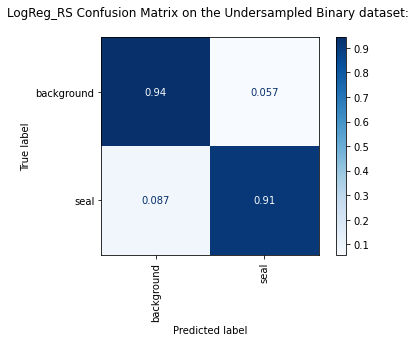

<Figure size 1440x1440 with 0 Axes>

RF Performance Results on the Undersampled Binary dataset: 
{'Accuracy': 0.9176981192734287, 'Precision': 0.614065180102916, 'Recall': 0.9203084832904884, 'F1 Score': 0.7366255144032923, 'Balanced Accuracy': 0.9188167439417718}
[[9986  900]
 [ 124 1432]]


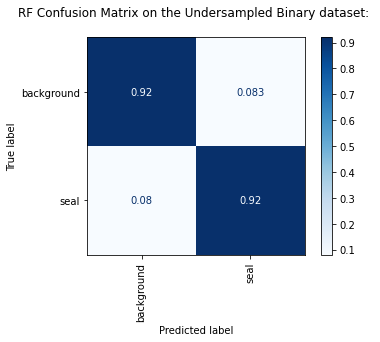

<Figure size 1440x1440 with 0 Axes>

MLP Performance Results on the Undersampled Binary dataset: 
{'Accuracy': 0.9577238386111557, 'Precision': 0.7657378740970072, 'Recall': 0.9537275064267352, 'F1 Score': 0.8494562106468232, 'Balanced Accuracy': 0.9560112821496161}
[[10432   454]
 [   72  1484]]


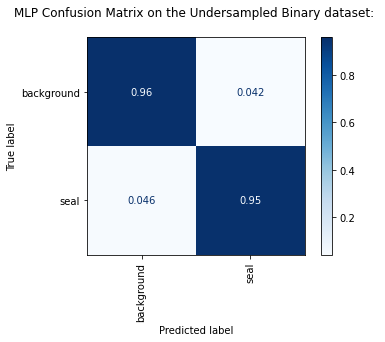

<Figure size 1440x1440 with 0 Axes>

In [39]:
# Tuned models 
binary_dataset_name = "Undersampled Binary"
multi_dataset_name = "Under- and Oversampled"
clfs = ["LogReg_RS", 'RF','MLP']
clf_binary_results = {}
clf_multi_results = {}

for clf in clfs:
    clf_model, clf_results = run_clf(X_train_B_undersampled, y_train_B_undersampled,
                                 X_val_B_PCA, y_val_B, binary_dataset_name,'binary',clf, None)
    clf_output = [clf_model, clf_results]
    clf_binary_results[clf] = clf_output


LogReg_RS Performance Results on the Under- and Oversampled dataset: 
{'Accuracy': 0.8485773991319724, 'Precision': 0.4197308846275921, 'Recall': 0.6519643093400931, 'F1 Score': 0.453008725796717, 'Balanced Accuracy': 0.6519643093400931}
[[9557  218  214  699  199]
 [   4   24    2   13   12]
 [   5    4   34    0    7]
 [  46   47   11  266   84]
 [  22  100    9  188  677]]


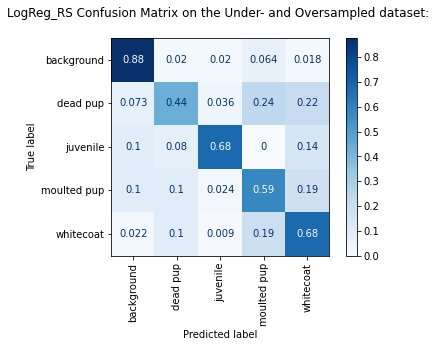

<Figure size 1440x1440 with 0 Axes>

RF Performance Results on the Under- and Oversampled dataset: 
{'Accuracy': 0.8685902588008358, 'Precision': 0.4804188850437397, 'Recall': 0.5142811494560918, 'F1 Score': 0.45968377960501333, 'Balanced Accuracy': 0.5142811494560918}
[[9827    1   38  342  679]
 [   8    3    0   13   31]
 [   4    0   24    1   21]
 [  68    0    4  148  234]
 [  53    4    2  132  805]]


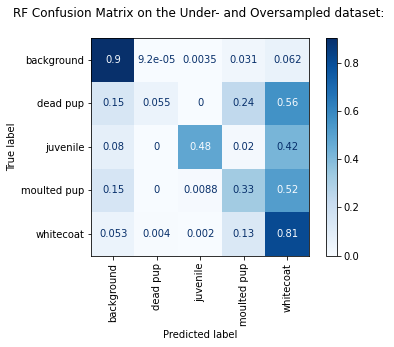

<Figure size 1440x1440 with 0 Axes>

MLP Performance Results on the Under- and Oversampled dataset: 
{'Accuracy': 0.9166532711782671, 'Precision': 0.498063228054486, 'Recall': 0.628978137206622, 'F1 Score': 0.5464586453999523, 'Balanced Accuracy': 0.628978137206622}
[[10342    39    47   261   198]
 [    3    12     0    13    27]
 [    2     0    34     3    11]
 [   39     8    10   230   167]
 [   16    18    10   165   787]]


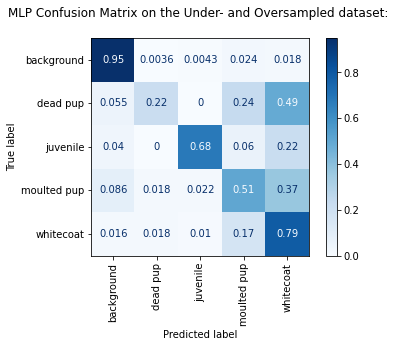

<Figure size 1440x1440 with 0 Axes>

In [40]:
for clf in clfs:
    clf_model, clf_results = run_clf(X_train_M_UO, y_train_M_UO,
                                 X_val_M_PCA, y_val_M, multi_dataset_name,'multi',clf, None)
    clf_output = [clf_model, clf_results]
    clf_multi_results[clf] = clf_output

### Plot the ROC curve 

the ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity.

In [41]:
clf_binary_results 
clf_multi_results
def plot_roc_curve(results):
    plt.figure(figsize=(8, 6))
    plt.xlim(0, 0.2)
    plt.ylim(0.8, 1)
    for key in results:
        model = results[key][0]
        y_pred_proba = model.predict_proba(X_val_B_PCA)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_val_B, y_pred_proba, pos_label='seal')
        plt.plot(fpr, tpr, linewidth=2, label=key)

    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

def plot_precision_recall_curve(results):
    plt.figure(figsize=(8, 6))
    plt.xlim(0, 0.2)
    plt.ylim(0.8, 1)
    for key in results:
        model = results[key][0]
        y_pred_proba = model.predict_proba(X_val_B_PCA)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y_val_B, y_pred_proba, pos_label='seal')
        plt.plot(precisions, recalls, linewidth=2, label=key)

    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall', fontsize=16) 
    plt.ylabel('Precision', fontsize=16)    
    plt.grid(True)
    plt.title('Precision Recall curve')
    plt.legend(loc='best')
    plt.show()
        



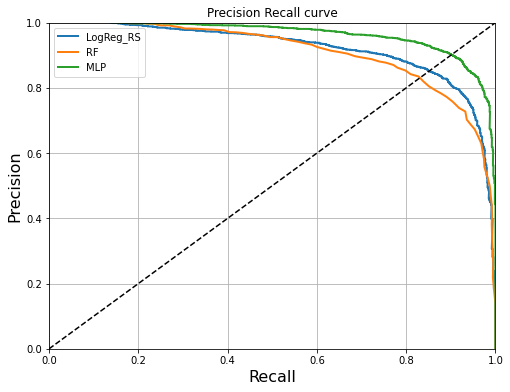

In [42]:
plot_precision_recall_curve(clf_binary_results)

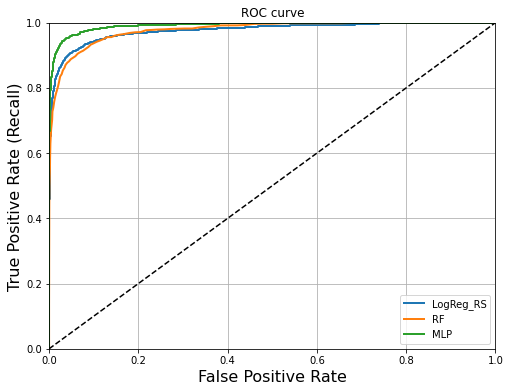

In [44]:
plot_roc_curve(clf_binary_results)

# 4. Predictions on the Test Set

Here i pick the top performing models on the binary and multi datasets to make predictions on the test set. 
The predictions are then saved in a csv file for submission. 


In [50]:
# Binary model 
final_binary_model = clf_binary_results["MLP"][0]
y_test_Binary = final_binary_model.predict(X_test_binary_PCA)
y_test_binary = pd.DataFrame(y_test_Binary).to_csv('final output/y_test_Binary.csv')

In [51]:
# multi model 
final_multi_model = clf_multi_results["MLP"][0]
y_test_Multi = final_multi_model.predict(X_test_multi_PCA)
y_test_Multi = pd.DataFrame(y_test_Multi).to_csv('final output/y_test_Multi.csv')